In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [3]:

laptop_data = pd.read_csv("F:\Internships\ProdigyInfotech\laptop_data.csv")
laptop_data

,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price
0,0.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 2.3GHz,8GB,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37kg,71378.6832
1,1.0,Apple,Ultrabook,13.3,1440x900,Intel Core i5 1.8GHz,8GB,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34kg,47895.5232
2,2.0,HP,Notebook,15.6,Full HD 1920x1080,Intel Core i5 7200U 2.5GHz,8GB,256GB SSD,Intel HD Graphics 620,No OS,1.86kg,30636.0000
3,3.0,Apple,Ultrabook,15.4,IPS Panel Retina Display 2880x1800,Intel Core i7 2.7GHz,16GB,512GB SSD,AMD Radeon Pro 455,macOS,1.83kg,135195.3360
4,4.0,Apple,Ultrabook,13.3,IPS Panel Retina Display 2560x1600,Intel Core i5 3.1GHz,8GB,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37kg,96095.8080
...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1298.0,Lenovo,2 in 1 Convertible,14,IPS Panel Full HD / Touchscreen 1920x1080,Intel Core i7 6500U 2.5GHz,4GB,128GB SSD,Intel HD Graphics 520,Windows 10,1.8kg,33992.6400
1299,1299.0,Lenovo,2 in 1 Convertible,13.3,IPS Panel Quad HD+ / Touchscreen 3200x1800,Intel Core i7 6500U 2.5GHz,16GB,512GB SSD,Intel HD Graphics 520,Windows 10,1.3kg,79866.7200
1300,1300.0,Lenovo,Notebook,14,1366x768,Intel Celeron Dual Core N3050 1.6GHz,2GB,64GB Flash Storage,Intel HD Graphics,Windows 10,1.5kg,12201.1200
1301,1301.0,HP,Notebook,15.6,1366x768,Intel Core i7 6500U 2.5GHz,6GB,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19kg,40705.9200


In [5]:
# Data Cleaning
print("Number of NA in laptop_data:", laptop_data.isna().sum().sum())

# Remove NA values
laptop_data = laptop_data.dropna()

# Rename 'Unnamed..0' column to 'id'
laptop_data = laptop_data.rename(columns={"Unnamed..0": "id"})

Number of NA in laptop_data: 360


In [6]:
# Replace '?' with NA
laptop_data = laptop_data.replace('?', np.nan)
laptop_data = laptop_data.dropna()

In [7]:
# Convert to numeric
laptop_data['Inches'] = pd.to_numeric(laptop_data['Inches'])
laptop_data['Ram'] = laptop_data['Ram'].str.extract('(\d+)').astype(int)
laptop_data['Weight'] = laptop_data['Weight'].str.replace('kg', '').astype(float)


In [19]:
# Extract screen resolution size
laptop_data['ScreenResolution'] = laptop_data['ScreenResolution'].str.extract('(\d+x\d+)')


In [28]:
import re

# Convert 'Cpu' column to strings (if it's not already)
laptop_data['Cpu'] = laptop_data['Cpu'].astype(str)

# Define a function to extract the numeric part
def extract_cpu_speed(cpu_string):
    match = re.search(r'(\d+\.\d+)', cpu_string)
    if match:
        return float(match.group())
    else:
        return None

# Apply the function to the 'Cpu' column
laptop_data['Cpu'] = laptop_data['Cpu'].apply(extract_cpu_speed)

In [30]:
# Extract GPU maker
laptop_data['GpuMaker'] = laptop_data['Gpu'].str.extract(r'(Nvidia|AMD|Samsung|Intel)')

In [36]:
import re

# Convert 'Memory' column to strings (if it's not already)
laptop_data['Memory'] = laptop_data['Memory'].astype(str)

# Define a function to extract and convert memory space
def extract_and_convert_memory_space(memory_string):
    matches = re.findall(r'(\d+\.*\d*)', memory_string)
    
    if matches:
        total_memory = 0
        for match in matches:
            numeric_value = float(match)
            if 'TB' in memory_string:
                numeric_value *= 1000
            total_memory += numeric_value
        return str(int(total_memory))
    else:
        return '0'

# Apply the function to the 'Memory' column
laptop_data['MemorySpace'] = laptop_data['Memory'].apply(extract_and_convert_memory_space)

# Extract and convert memory type
laptop_data['MemoryType'] = laptop_data['Memory'].apply(lambda x: 'Hybrid' if '+' in x else x).str.extract(r'(SSD|HDD|Flash Storage|Hybrid)').astype(str)

In [40]:
# Convert 'MemorySpace' column to strings (if it's not already)
laptop_data['MemorySpace'] = laptop_data['MemorySpace'].astype(str)

# Define a function to compute MemorySpace
def compute_memory_space(memory_string):
    if '+' in memory_string:
        values = memory_string.split('+')
        total_memory = 0
        for value in values:
            numeric_value = float(value)
            if 'TB' in memory_string:
                numeric_value *= 1000
            total_memory += numeric_value
        return str(int(total_memory))
    else:
        return memory_string

# Apply the function to the 'MemorySpace' column
laptop_data['MemorySpace'] = laptop_data['MemorySpace'].apply(compute_memory_space)

In [42]:
##Step 3: Data Analysis

# Remove outliers
q1 = laptop_data['Price'].quantile(0.25)
q3 = laptop_data['Price'].quantile(0.75)
iqr = q3 - q1
lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr
laptop_data = laptop_data[(laptop_data['Price'] >= lower_bound) & (laptop_data['Price'] <= upper_bound)]
laptop_data


,Unnamed: 0,Company,TypeName,Inches,ScreenResolution,Cpu,Ram,Memory,Gpu,OpSys,Weight,Price,GpuMaker,MemorySpace,MemoryType
0,0.0,Apple,Ultrabook,13.3,2560x1600,2.3,8,128GB SSD,Intel Iris Plus Graphics 640,macOS,1.37,71378.6832,Intel,128,SSD
1,1.0,Apple,Ultrabook,13.3,1440x900,1.8,8,128GB Flash Storage,Intel HD Graphics 6000,macOS,1.34,47895.5232,Intel,128,Flash Storage
2,2.0,HP,Notebook,15.6,1920x1080,2.5,8,256GB SSD,Intel HD Graphics 620,No OS,1.86,30636.0000,Intel,256,SSD
3,3.0,Apple,Ultrabook,15.4,2880x1800,2.7,16,512GB SSD,AMD Radeon Pro 455,macOS,1.83,135195.3360,AMD,512,SSD
4,4.0,Apple,Ultrabook,13.3,2560x1600,3.1,8,256GB SSD,Intel Iris Plus Graphics 650,macOS,1.37,96095.8080,Intel,256,SSD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1298,1298.0,Lenovo,2 in 1 Convertible,14.0,1920x1080,2.5,4,128GB SSD,Intel HD Graphics 520,Windows 10,1.80,33992.6400,Intel,128,SSD
1299,1299.0,Lenovo,2 in 1 Convertible,13.3,3200x1800,2.5,16,512GB SSD,Intel HD Graphics 520,Windows 10,1.30,79866.7200,Intel,512,SSD
1300,1300.0,Lenovo,Notebook,14.0,1366x768,1.6,2,64GB Flash Storage,Intel HD Graphics,Windows 10,1.50,12201.1200,Intel,64,Flash Storage
1301,1301.0,HP,Notebook,15.6,1366x768,2.5,6,1TB HDD,AMD Radeon R5 M330,Windows 10,2.19,40705.9200,AMD,1000,HDD


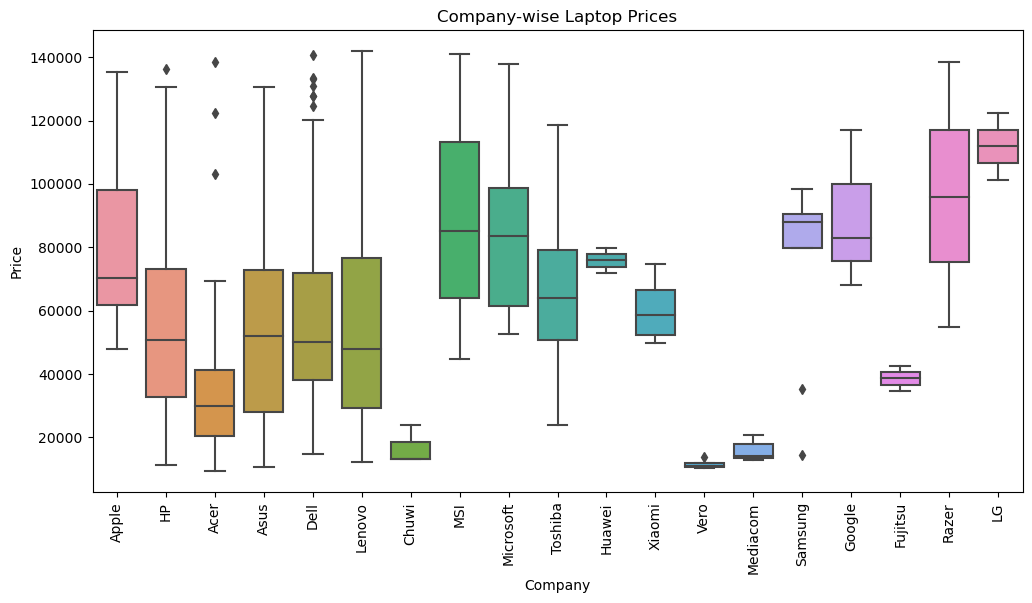

In [83]:
# Visual Analysis
plt.figure(figsize=(12, 6))
sns.boxplot(x=laptop_data['Company'], y=laptop_data['Price'])
plt.xticks(rotation=90)
plt.title('Company-wise Laptop Prices')
plt.show()

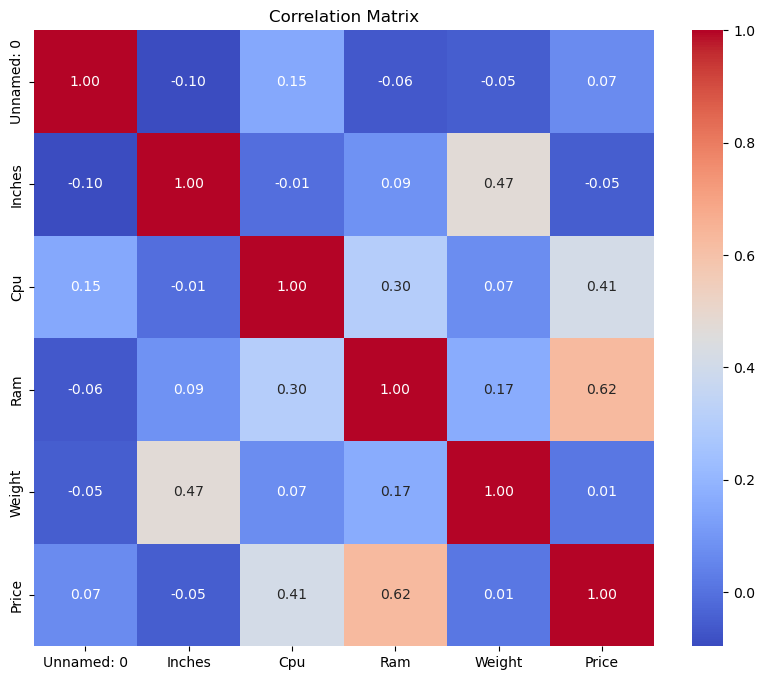

In [82]:
#Correlation Matrix

# Select the numeric columns for correlation analysis
numeric_columns = laptop_data.select_dtypes(include=['number'])

# Compute the correlation matrix for numeric columns
correlation_matrix = numeric_columns.corr()

# Create a correlation heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [80]:
missing_gpu_maker = laptop_data['GpuMaker'].isnull()
print(missing_gpu_maker.sum())
laptop_data['GpuMaker'].fillna("Unknown", inplace=True)
laptop_data.dropna(subset=['GpuMaker'], inplace=True)

# Impute missing 'GpuMaker' values with "Unknown"
laptop_data['GpuMaker'].fillna("Unknown", inplace=True)

missing_values = laptop_data.isnull().sum()
print(missing_values)

1
Unnamed: 0          0
Company             0
TypeName            0
Inches              0
ScreenResolution    0
Cpu                 0
Ram                 0
Memory              0
Gpu                 0
OpSys               0
Weight              0
Price               0
GpuMaker            0
MemorySpace         0
MemoryType          0
dtype: int64


In [81]:
# Replace 'Unknown' with a numeric placeholder (-1)
laptop_data['Cpu'].replace('Unknown', -1, inplace=True)

# Feature selection and one-hot encoding
X = laptop_data[['Ram', 'Cpu', 'MemoryType']]
X_encoded = pd.get_dummies(X, columns=['MemoryType'], drop_first=True)

# Target variable
y = laptop_data['Price']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.25, random_state=23)

# Build and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict on the training set and calculate RMSE
y_pred_train = model.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
print(f"RMSE on the training set: {rmse_train:.2f}")

# Predict on the test set and calculate RMSE
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"RMSE on the test set: {rmse_test:.2f}")


RMSE on the training set: 20744.97
RMSE on the test set: 21652.87


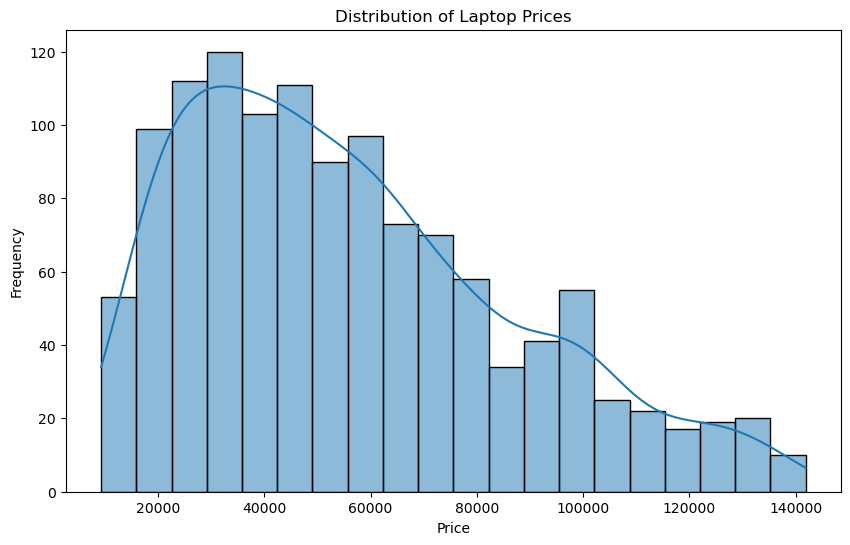

In [70]:
##Data Visualization

#1. Histogram of laptop prices

plt.figure(figsize=(10, 6))
sns.histplot(laptop_data['Price'], bins=20, kde=True)
plt.title("Distribution of Laptop Prices")
plt.xlabel("Price")
plt.ylabel("Frequency")
plt.show()

<class 'pandas.core.series.Series'>


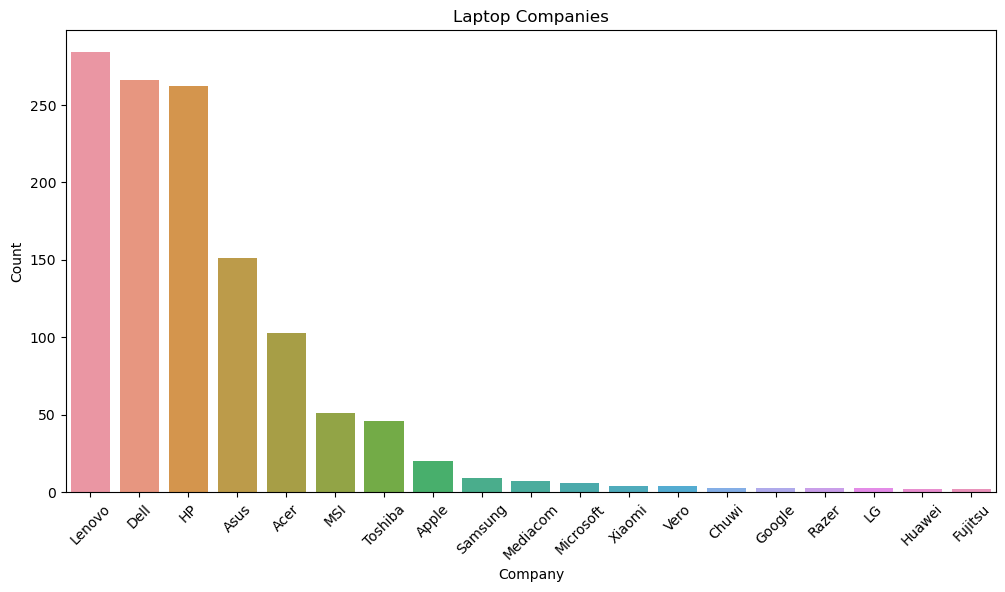

In [73]:
#2. barplot of laptop companies

print(type(laptop_data['Company']))
order_data = laptop_data['Company'].value_counts().index  #order data

plt.figure(figsize=(12, 6))
sns.countplot(data=laptop_data, x='Company', order=order_data)
plt.title("Laptop Companies")
plt.xlabel("Company")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()

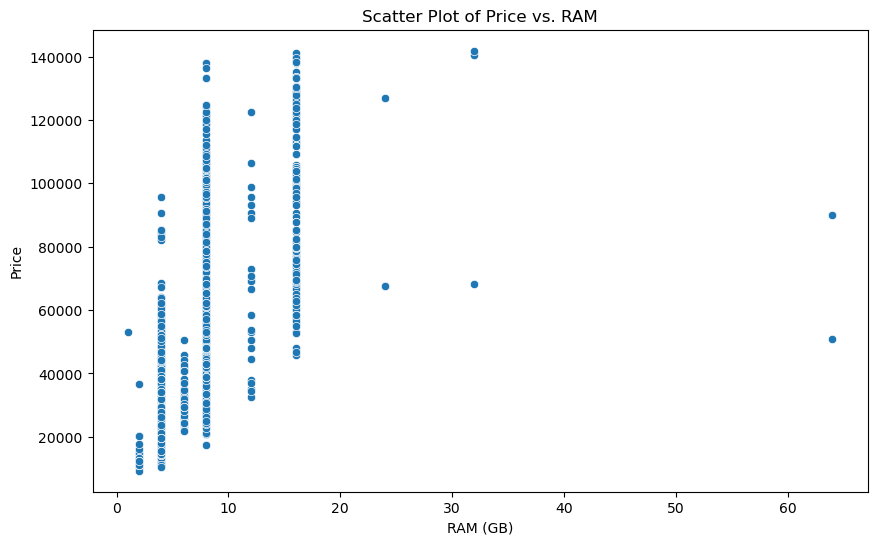

In [74]:
#3. ScatterPlot: price Vs RAM
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Ram', y='Price', data=laptop_data)
plt.title("Scatter Plot of Price vs. RAM")
plt.xlabel("RAM (GB)")
plt.ylabel("Price")
plt.show()

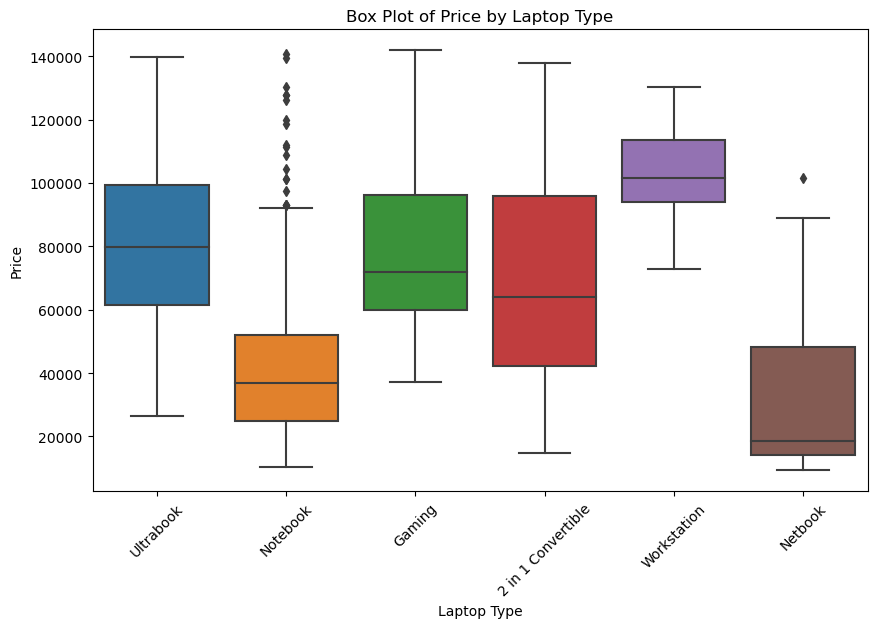

In [75]:
#4. Box Plot: price by laptop type:

plt.figure(figsize=(10, 6))
sns.boxplot(x='TypeName', y='Price', data=laptop_data)
plt.title("Box Plot of Price by Laptop Type")
plt.xlabel("Laptop Type")
plt.ylabel("Price")
plt.xticks(rotation=45)
plt.show()

C:\Users\RAJAN\anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


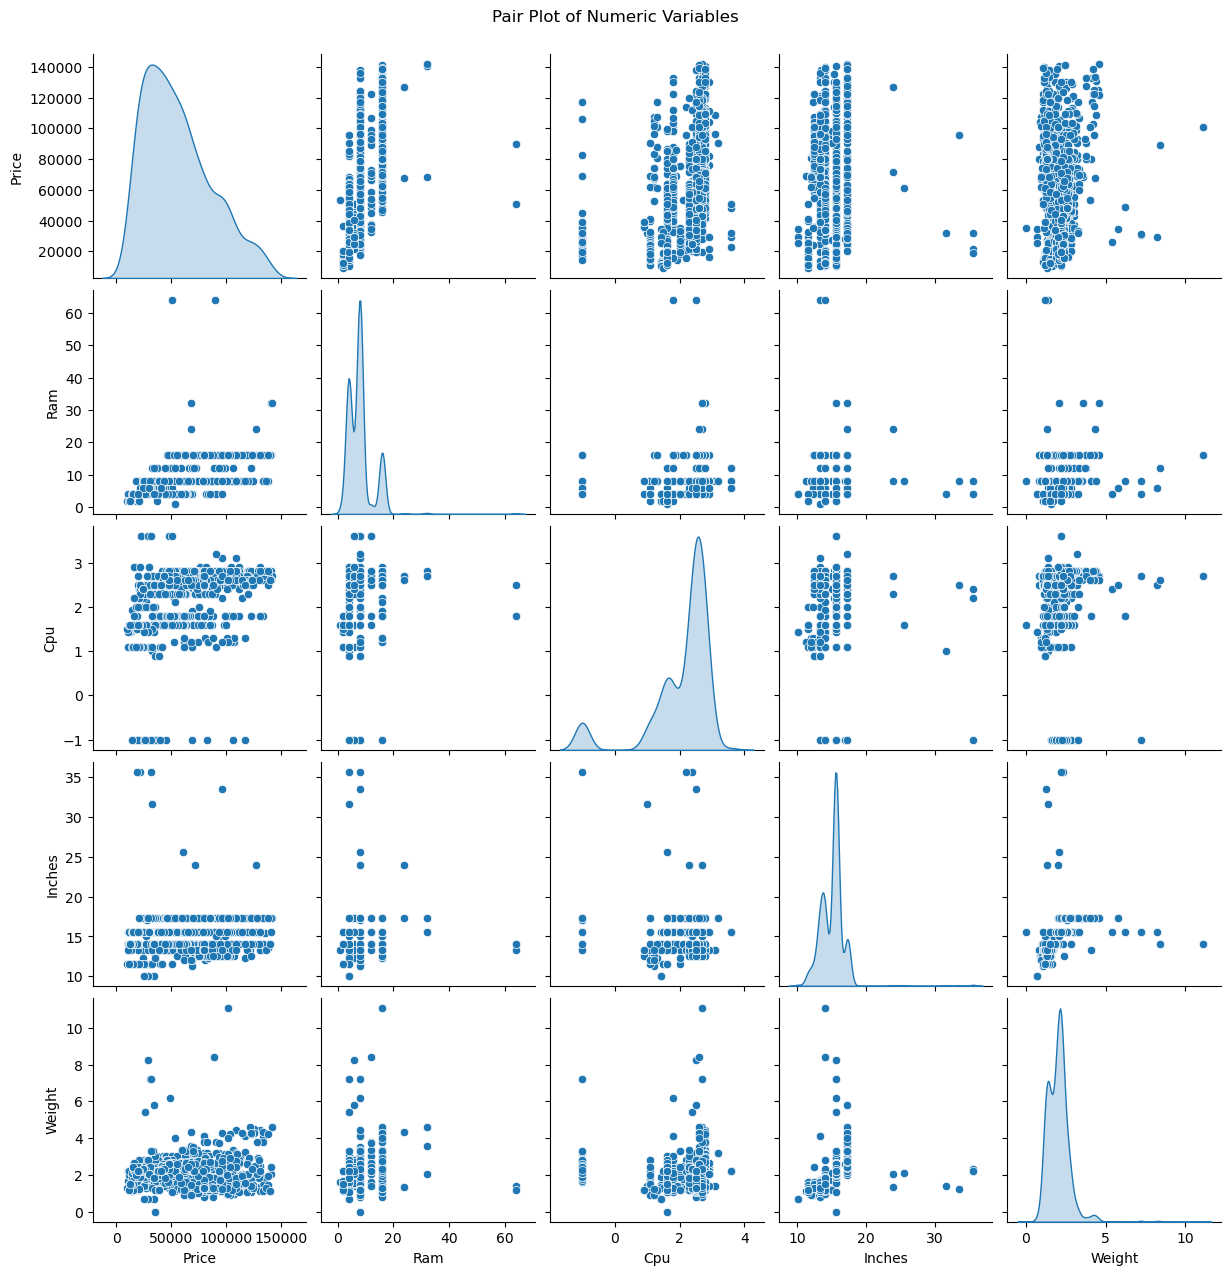

In [77]:
#5. Pair Plot for Numeric Variables: 

sns.pairplot(laptop_data[['Price', 'Ram', 'Cpu', 'Inches', 'Weight']], diag_kind='kde')
plt.suptitle("Pair Plot of Numeric Variables", y=1.02)
plt.show()